In [ ]:
import os
os.environ['YT_DEST'] = '/home/kwoksun2/anaconda2/pkgs/yt-3.3.5-np111py27_2/'
import numpy as np
from dengo.chemical_network import \
    ChemicalNetwork, \
    reaction_registry, \
    cooling_registry, species_registry
import dengo.primordial_rates, dengo.primordial_cooling
from dengo.chemistry_constants import tiny, kboltz, mh
import yt
import numpy
from IPython.display import Image
import matplotlib.pyplot as plt

import pyximport
pyximport.install(setup_args={"include_dirs":np.get_include()},
                      reload_support=True, inplace=True)


In [ ]:
def equil_values(init_values, primordial, t =3.16e13, niter= 1e5, full_output = False):
    
    primordial.write_solver("sunny", output_dir = ".",
                            init_values=init_values,
                            input_is_number=False)

    sunny_solver_run = pyximport.load_module("sunny_solver_run",
                                "sunny_solver_run.pyx",
                                build_inplace = True, pyxbuild_dir = "_dengo_temp")
    rv, rv_int = sunny_solver_run.run_sunny(init_values, t, niter=niter) ;
    
    mask = rv_int['successful']
    
    if full_output:
        return rv_int, 0
    else:
        return rv_int['H_1'][:, mask][:,-1] / init_values['density'], rv_int['t'][mask][-1]

In [78]:
# only two species

def Init_values_He(temperature, density, fH, reaction_k):
    
    X = 1.0
    # initialize and setup the network
    dengo.primordial_rates.setup_primordial()
    primordial = ChemicalNetwork()

    for i in range(23):
        try: 
            if (i+1) not in [reaction_k]:
                primordial.add_reaction("k{0:02d}".format(i+1))
        except:
            pass
    
    
    primordial.init_temperature((1e0, 1e5))

    tiny = 1e-20

    # init_array are is in MASS fractional abundances
    init_array = density
    init_values = dict()
    
    init_values["He_1"]    = density * (1 - 0.76)/4.0026
    init_values["He_2"]    = tiny*density
    init_values["He_3"]    = tiny*density

    init_values["H_1"]     = density * (0.76)/1.00794
    init_values['H_2']     = tiny*density 
    init_values["H_m0"]    = tiny*density 

    init_values["H2_1"]    = tiny*density
    init_values["H2_2"]    = tiny*density
    # now everything in mass density
    init_values = primordial.convert_to_mass_density(init_values)
    init_values['de'] = primordial.calculate_free_electrons(init_values)
    # one signle value: again mass density
    init_values['density'] = primordial.calculate_total_density(init_values)
    number_density = primordial.calculate_number_density(init_values)

    # set up initial temperatures values used to define ge
    init_values['T'] = temperature

    # calculate ge (very crudely, no H2 help here)
    gamma = 5.0/3.0
    init_values['ge'] = ((temperature * number_density * kboltz)
                         / (init_values['density'] * mh * (gamma - 1)))
    return init_values, primordial

In [54]:
def main(fH, temp, den , full_output = False):
    
    
    temp = temp.flatten()
    den = den.flatten()
    
    h_array = numpy.zeros((len(temp), len(den)))
    t_array = numpy.zeros((len(den)))
    
    h_array = []
    t_array = []
    
    print(den)
    for iden, den_arr in enumerate(den):
        
        den_arr = numpy.ones((len(temp)))*den_arr
        
        init_values, primordial = Init_values(temp, den_arr, fH)
        h_array_now, t_array_now = equil_values(init_values, primordial, full_output = full_output)
        
        h_array.append(h_array_now)
        t_array.append(t_array_now)
        
    return h_array, t_array

In [20]:
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx

def make_plots( network, init, rv_int, solver_name = 'sundials', t_min = 1e0, t_max = 1e11, plot_fH = False ):
    
    rv_arr = rv_int
    
    mask = rv_arr['successful']
    t    = rv_arr['t'][mask]
    dt   = rv_arr['dt'][mask]

    plt.clf()
    skip_list = ['dt' ,'successful', 't','Ju', 'Jac', 'He_1', 'He_2', 'He_3']
    hydrogen_list = ['H_1','H_2','H2_1','H2_2','H_m0']
    
    
    # Calculate total electron density 
    # with the abundances from other species
    total_e = numpy.zeros((len(t)))
    for j in network.required_species:
        if j.name in rv_arr.keys() and j.name not in skip_list and j.name != 'dt':
            
            try:
                total_e += rv_arr[j.name][0][mask]  * j.free_electrons 
            except:
                pass
    
    de = rv_arr['de'][0][mask]
    # calculate total mass density of hydrogen
    # conservation of mass
    total_Hatoms = numpy.zeros((len(t)))
    for j in network.required_species:
        if j.name in hydrogen_list:
            total_Hatoms += rv_arr[j.name][0][mask] *j.weight
            

    f, axarr = plt.subplots(3, sharex=True, figsize=(10,15))
    
    ii = 0
    for i in rv_arr.keys():
        if i not in skip_list:
            
            hi = rv_arr[i][0][mask]
            if t_min == 1e0:
                axarr[0].semilogx(t,numpy.array(hi)/init[i][0]+ii, label=i) 
                ii+=1
            else:
                idx = find_nearest(t , t_min)
                axarr[0].semilogx(t[idx:] ,numpy.array(hi[idx:])/hi[idx] +1e-5 , label=i) 
                ii+=1



    h1 = rv_arr['H_1'][0][mask]
    h2 = rv_arr['H2_1'][0][mask]
    
    T0 = rv_arr['T'][0][mask][0]
    axarr[0].set_title('{}:  Temperature: {} K     Density: {} per cc '.format(solver_name, T0 , total_Hatoms[0]   ))
    axarr[0].set_xlabel('Time (s)')
    axarr[0].set_ylabel('Species abundances (normalized by initial values)')
    
    dt = rv_arr['dt'][mask]
 #   if t_min == 1e0:
 #       axarr[0].loglog(t, dt / dt[0], label=i) 
 #   else:
 #       idx = find_nearest(t , t_min)
 #       axarr[0].loglog(t[idx:] ,dt[idx:] / dt[idx], label=i) 
                
    

    de = rv_arr['de'][0][mask]
    
    axarr[0].legend(loc='best',fontsize='x-small')
    # plt.savefig(con_not_con+'-species-norm-nHe20.png')


    for i in rv_arr.keys():
        if i not in skip_list:
            hi = rv_arr[i][0][mask]
            axarr[1].loglog(t,hi, label=i) 


    axarr[1].set_xlabel('Time (s)')
    axarr[1].set_ylabel('Species abundances')

    axarr[1].legend(loc='best',fontsize='x-small')


    

    de = rv_arr['de'][0][mask]
    axarr[2].semilogx(t, (de/total_e) , label='de normalized by those from species', ls = '--', color = 'r')

    axarr[2].semilogx(t, ( total_Hatoms )/ total_Hatoms[0], label = 'mass density of H atoms' )
    
    
    print('de conserved?   ', de[-1]/total_e[-1])
    print('mass conserved? ' , ( total_Hatoms[-1] )/ total_Hatoms[0])
    
    
    if plot_fH:
        axarr[2].plot(t, h1/total_Hatoms, label="f(H)" )
    print('final f(H) = {}'.format(h1[-1]/total_Hatoms[-1]) )
    axarr[2].set_xlabel('Time (s)')
    axarr[2].set_ylabel('mass ratio of Hydrogen atom (fH)')
    axarr[2].legend()
    
    #axarr[2].set_xlim((t_min, t_max))
    
    T0 = rv_arr['T'][0][0]
    f.savefig(solver_name+'_nH={:.2E}_T={:.1E}.png'.format(total_Hatoms[0], T0) )
    plt.close(f)
    return solver_name+'_nH={:.2E}_T={:.1E}.png'.format(total_Hatoms[0], T0)

In [ ]:

class my_network:
    def __init__(self, T):
        self.T = T

from sympy import *

def equi_fH(rho, T, k):
    
    
    init, network = Init_values_He(T,rho, 0.0, k)
    
    # for i in network.required_species:
    #     print(network.print_ccode(i))
    #     for j in network.required_species:
    #         print(network.print_jacobian_component(i,j))

    mH = 1.0

    k13 = (network.reactions['k13'])
    k22 = (network.reactions['k22'])

    temp_network = my_network(T)

    k13coeff, k22coeff = (k13.coeff_fn(temp_network), k22.coeff_fn(temp_network))
    

    k13s, k22s, fHs, rhos = symbols(" k13 k22 fH rho")
    expr = k13s*(1 - fHs) /2 - k22s*fHs*fHs*rhos
    known_vals = [ (k13s, k13coeff), (k22s, k22coeff), (rhos, rho) ]
    new_expr = expr.subs(known_vals)
    new_expr_poly = Poly(new_expr, fHs)
    print('Temperature now: {} K'.format(T))
    poly_coeff = (new_expr_poly.coeffs())
    ans = numpy.roots(poly_coeff)
    print('fH: {}'.format(ans[ans>0]) )
    return ans[ans>0]

Temp_array = numpy.array([3.0e3])
# in atomic mass unit! not grams
rho = numpy.array([1.0e15])

In [7]:
def no_kth_reaction( kth = 1 ):

    ith_T = numpy.array([2000.0])
    rho = numpy.array([1.0e20])
    
    
    fH = equi_fH(rho, ith_T, 0)

    init, primordial = Init_values_He( ith_T , rho, fH , kth )

    primordial.write_solver("sunny", output_dir = ".",
                                init_values=init,
                                input_is_number=False)

    sunny_solver_run = pyximport.load_module("sunny_solver_run",
                                    "sunny_solver_run.pyx",
                                    build_inplace = True, pyxbuild_dir = "_dengo_temp")


    rv, rv_int_be_chem = sunny_solver_run.run_sunny(init, 1e14 , niter=1e5 )
    return rv_int_be_chem
    succ_flag = rv_int_be_chem['successful']
    loc = numpy.arange(len(succ_flag))
    flag = loc[succ_flag][-1]
    
    result = {}
    for spe in primordial.required_species:
        sp = spe.name
        result[sp] = rv_int_be_chem[sp][0][flag]
    result['t'] = rv_int_be_chem['t'][flag]
    
    return result

In [79]:
%%time
ith_T = numpy.array([2000.0])
rho = numpy.array([1.0e10])
    
fH = equi_fH(rho, ith_T, 1.0 - 1e-5)
fH = 1.0 - 1e-5
init, primordial = Init_values_He( ith_T , rho, fH , 0)

primordial.write_solver("sunny", output_dir = ".",
                            init_values=init,
                            input_is_number=False)

sunny_solver_run = pyximport.load_module("sunny_solver_run",
                                "sunny_solver_run.pyx",
                                build_inplace = True, pyxbuild_dir = "_dengo_temp")


rv, rv_int_be_chem = sunny_solver_run.run_sunny(init, 1e12 , niter=2e5 )

Adding reaction: k01 : 1*H_1 + 1*de => 1*H_2 + 2*de
Adding reaction: k02 : 1*H_2 + 1*de => 1*H_1
Adding reaction: k03 : 1*He_1 + 1*de => 1*He_2 + 2*de
Adding reaction: k04 : 1*He_2 + 1*de => 1*He_1
Adding reaction: k05 : 1*He_2 + 1*de => 1*He_3 + 2*de
Adding reaction: k06 : 1*He_3 + 1*de => 1*He_2
Adding reaction: k07 : 1*H_1 + 1*de => 1*H_m0
Adding reaction: k08 : 1*H_m0 + 1*H_1 => 1*H2_1 + 1*de
Adding reaction: k09 : 1*H_1 + 1*H_2 => 1*H2_2
Adding reaction: k10 : 1*H2_2 + 1*H_1 => 1*H2_1 + 1*H_2
Adding reaction: k11 : 1*H2_1 + 1*H_2 => 1*H2_2 + 1*H_1
Adding reaction: k12 : 1*H2_1 + 1*de => 2*H_1 + 1*de
Adding reaction: k13 : 1*H2_1 + 1*H_1 => 3*H_1
Adding reaction: k14 : 1*H_m0 + 1*de => 1*H_1 + 2*de
Adding reaction: k15 : 1*H_m0 + 1*H_1 => 2*H_1 + 1*de
Adding reaction: k16 : 1*H_m0 + 1*H_2 => 2*H_1
Adding reaction: k17 : 1*H_m0 + 1*H_2 => 1*H2_2 + 1*de
Adding reaction: k18 : 1*H2_2 + 1*de => 2*H_1
Adding reaction: k19 : 1*H2_2 + 1*H_m0 => 1*H_1 + 1*H2_1
Adding reaction: k21 : 2*H_1 

('de conserved?   ', 2.5000034337259778)
('mass conserved? ', 0.99999999999999811)
final f(H) = 0.986547312751
be_chem_solve_nH=7.60E+09_T=2.0E+03.png


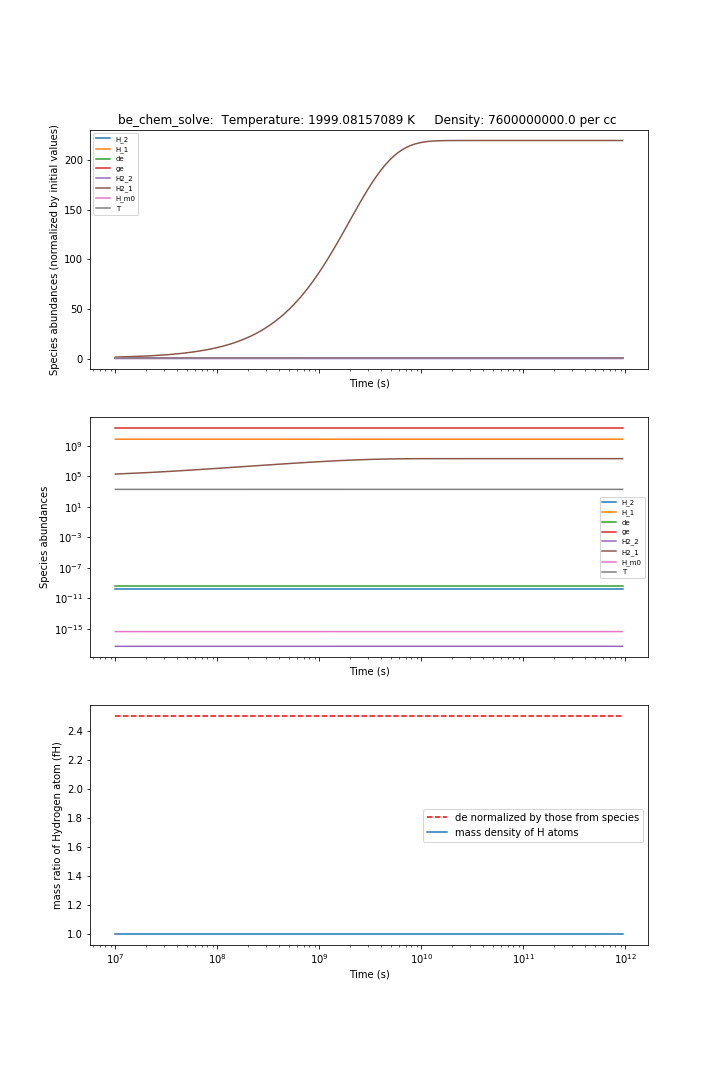

In [80]:
mask = rv_int_be_chem['successful']
t_arr = rv_int_be_chem['t'][mask]

png_name = make_plots( primordial, init, rv_int_be_chem, solver_name = 'be_chem_solve', t_min = t_arr[0], t_max = t_arr[1]  )
print(png_name)
Image(png_name)

In [81]:
rv_int_be_chem['H_1'][0][mask]

array([  7.53993807e+09,   7.53972645e+09,   7.53949488e+09,
         7.53924161e+09,   7.53896477e+09,   7.53866234e+09,
         7.53833220e+09,   7.53797209e+09,   7.53757962e+09,
         7.53715227e+09,   7.53668744e+09,   7.53618239e+09,
         7.53563434e+09,   7.53504044e+09,   7.53439784e+09,
         7.53370368e+09,   7.53295523e+09,   7.53214987e+09,
         7.53128519e+09,   7.53035913e+09,   7.52937000e+09,
         7.52831668e+09,   7.52719867e+09,   7.52601632e+09,
         7.52477092e+09,   7.52346486e+09,   7.52210181e+09,
         7.52068686e+09,   7.51922662e+09,   7.51772932e+09,
         7.51620486e+09,   7.51466473e+09,   7.51312197e+09,
         7.51159089e+09,   7.51008679e+09,   7.50862552e+09,
         7.50722296e+09,   7.50589437e+09,   7.50465375e+09,
         7.50351311e+09,   7.50248187e+09,   7.50156632e+09,
         7.50076924e+09,   7.50008978e+09,   7.49952356e+09,
         7.49906304e+09,   7.49869812e+09,   7.49841688e+09,
         7.49820648e+09,

In [82]:
%%time
ith_T = numpy.array([2000.0])
rho = numpy.array([1.0e10])
fH = equi_fH(rho, ith_T, 0)

init, primordial = Init_values_He( ith_T , rho, fH, 0 )

primordial.write_solver("sundials_time", solver_template = "sundials_time", 
                    ode_solver_source = "cvodes_solver_time.C", 
                    output_dir = ".",
                        init_values=init,
                        input_is_number=False)

sundials_solver_run = pyximport.load_module("sundials_time_solver_run",
                            "sundials_time_solver_run.pyx",
                            build_inplace = True, pyxbuild_dir = "_dengo_temp")
rv, rv_int_sundials = sundials_solver_run.run_sundials_time(init, 1.0e12 , niter=1e6) # , dtarr = dt_arr)

Adding reaction: k01 : 1*H_1 + 1*de => 1*H_2 + 2*de
Adding reaction: k02 : 1*H_2 + 1*de => 1*H_1
Adding reaction: k03 : 1*He_1 + 1*de => 1*He_2 + 2*de
Adding reaction: k04 : 1*He_2 + 1*de => 1*He_1
Adding reaction: k05 : 1*He_2 + 1*de => 1*He_3 + 2*de
Adding reaction: k06 : 1*He_3 + 1*de => 1*He_2
Adding reaction: k07 : 1*H_1 + 1*de => 1*H_m0
Adding reaction: k08 : 1*H_m0 + 1*H_1 => 1*H2_1 + 1*de
Adding reaction: k09 : 1*H_1 + 1*H_2 => 1*H2_2
Adding reaction: k10 : 1*H2_2 + 1*H_1 => 1*H2_1 + 1*H_2
Adding reaction: k11 : 1*H2_1 + 1*H_2 => 1*H2_2 + 1*H_1
Adding reaction: k12 : 1*H2_1 + 1*de => 2*H_1 + 1*de
Adding reaction: k13 : 1*H2_1 + 1*H_1 => 3*H_1
Adding reaction: k14 : 1*H_m0 + 1*de => 1*H_1 + 2*de
Adding reaction: k15 : 1*H_m0 + 1*H_1 => 2*H_1 + 1*de
Adding reaction: k16 : 1*H_m0 + 1*H_2 => 2*H_1
Adding reaction: k17 : 1*H_m0 + 1*H_2 => 1*H2_2 + 1*de
Adding reaction: k18 : 1*H2_2 + 1*de => 2*H_1
Adding reaction: k19 : 1*H2_2 + 1*H_m0 => 1*H_1 + 1*H2_1
Adding reaction: k21 : 2*H_1 

('de conserved?   ', 2.500003433725964)
('mass conserved? ', 0.99999999999999845)
final f(H) = 0.986547312751


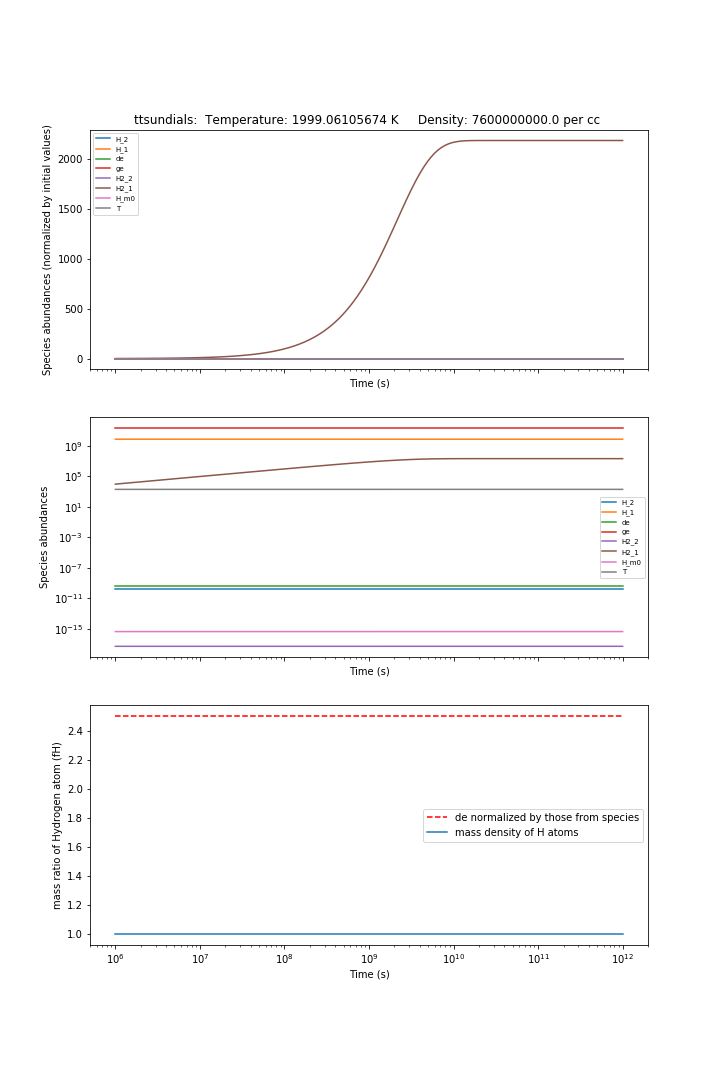

In [83]:
mask = rv_int_sundials['successful']
t_arr = rv_int_sundials['t'][mask]
png_name = make_plots( primordial, init, rv_int_sundials, solver_name = 'ttsundials', t_min = t_arr[0], t_max = t_arr[-1])
Image(png_name)



In [85]:
flag = rv_int_sundials['successful']
print(rv_int_sundials['H_1'][0][flag][-1])
flag = rv_int_be_chem['successful']
rv_int_be_chem['H_1'][0][flag][0]*1.00794 

7497759576.91


7599805175.3874454

In [86]:
rv_int_be_chem['H2_1'][0][flag][0]*1.00794 

97412.306277475844

In [ ]:
plt.hist( rv_int_sundials['t'][:-1] - rv_int_sundials['t'][1:] + (rv_int_sundials['dt'][1:]) )

In [ ]:
(rv_int_sundials['dt'][mask])

In [ ]:
# RUNTIME STATISTICS

be_stat_rtime = [7.34, 7.23, 7.39, 7.97, 9.67]
sundials_stat_rtime = [6.57,6.63, 6.56,6.71, 23.3]

sundials_stat_sim_time = [1e12, 1e12, 1e12, 8.323e11, 0.136]
be_stat_sim_time = [1e12,1e12,1e12, 1.914e10, 3.3e6]
Temp_array = [1000,2000,3000,4000,5000]

In [ ]:
plt.clf()
plt.plot(Temp_array, be_stat_rtime, label='BE run time (s)')
plt.plot(Temp_array, sundials_stat_rtime, label='Sundials run time (s)')
plt.xlabel('Temperature (K) at a fixed density 1e20 per cc')
plt.ylabel('Run time (s)')
plt.legend()
plt.show()

In [ ]:
plt.clf()
plt.semilogy(Temp_array, be_stat_sim_time, label='BE sim time (s)')
plt.semilogy(Temp_array, sundials_stat_sim_time, label='Sundials sim time (s)')
plt.xlabel('Temperature (K) at a fixed density 1e20 per cc')
plt.ylabel('time passed in the simulation (s)')
plt.legend()
plt.show()

In [ ]:
plt.clf()
fig, ax1 = plt.subplots()

ax1.plot(Temp_array, be_stat_rtime, label='BE run time (s)',color='r' )
ax1.plot(Temp_array, sundials_stat_rtime, label='Sundials run time (s)', color='r', ls='--')
ax1.set_xlabel('Temperature (K) at a fixed density 1e20 per cc')
ax1.set_ylabel('Wall time (s)',color='r')


ax2 = ax1.twinx()
ax2.semilogy(Temp_array, be_stat_sim_time, label='BE sim time (s)', color='b')
ax2.semilogy(Temp_array, sundials_stat_sim_time, label='Sundials sim time (s)',color='b', ls = '--')
ax2.set_xlabel('Temperature (K) at a fixed density 1e20 per cc')
ax2.set_ylabel('time passed in the simulation (s)', color='b')
ax1.legend(loc='best')
fig.tight_layout()
plt.show()

In [ ]:
ith_T = numpy.array([2000.0])
rho = numpy.array([1.0e10])
fH = equi_fH(rho, ith_T, 0)


fH = 1.0 -1e-5
init, primordial = Init_values_He( ith_T , rho, fH, 0 )

In [68]:
flag = rv_int_sundials['successful']
a = 0
for i in primordial.required_species:
    print(i,rv_int_sundials[i.name][0][flag][0])
    #print(i,init[i.name], i.weight)
    print('---------------------------')
    if i.name != 'ge':
        a +=init[i.name]*i.weight
print(a)

(Species: H2_1, 9476.5233143396781)
---------------------------
(Species: H2_2, 4.0103654287233648e-18)
---------------------------
(Species: ge, 232395979274.18546)
---------------------------
(Species: He_1, 149804366.57117131)
---------------------------
(Species: H_m0, 2.0444259894837904e-16)
---------------------------
(Species: He_3, 2.4983748071879206e-11)
---------------------------
(Species: He_2, 2.4983748071879306e-11)
---------------------------
(Species: H_1, 7480715373.4263716)
---------------------------
(Species: de, 2.2376942181958925e-10)
---------------------------
(Species: H_2, 1.488183780361847e-10)
---------------------------
[  9.99998921e+09]


In [ ]:
rv_int_be_chem['T'][0][flag]